# AM216 Final Project  
Wen Rui Liau  
David Zheng


## Objective:

To disambiguate an entity through its relationship with its neighboring entities utilizing graph embeddings. 

*Imagine the statement:* **Paris** is the capital of **France**.  
*In this context, does* Paris = (Paris Hilton), (Paris, France), (Paris, Arkansas)?

## Abstract
Entity-linking is a process of assigning a unique identity to entities in a text. In our project, we seek to disambiguate an entity through its relationship with its neighboring entities utilizing graph embeddings. Entity-linking is important as it allows researchers to extract abstract representations from text as well as seperate relevant concepts from non-meaningful text. We present our method of performing entity linking using the shortest cosine distance. We compare our embedding model with a naive baseline model that selects the entity with the highest view-count. After tuning our embedding model, it outperforms the baseline by achieving superior accuracy scores.

## Motivation

In natural language processing, entity linking is the task of assigning a unique identifier to entities mentioned in a corpus of text. Entities can refer to famous individuals, locations or companies etc. A classical example is as follows: Given the sentence "Paris is the capital of France", we want to determine that "Paris" refers to the city of Paris and not to Paris Hilton or any other entity that could be referred to as "Paris"  (Paris Hilton), (Paris, France), (Paris, Arkansas).

![entity-linking](https://drive.google.com/uc?id=1MlbsdkzUzFonPb_VIgcnwyCGJHCpYjgk)

In our project, we will be exploring the use of graph embeddings to generate a model which can accurately and efficiently execute these named entity linking.


## Methodology
We will be using the Kensho-Derived Wikimedia Dataset (KDWD) to answer this question. The KDWD is built upon the Wikipedia-Wikidata combination and consists of three different layers as described in this blog post: The base layer is the English Wikipedia corpus, the middle layer labels the corpus by indicating which text spans are URL links to other entries, and the top layer (knowledge layer) connects the Wikipedia links to items in the Wikidata knowledge graph.

In our dataset, the top layer is crucial to our application. It provides statements as triples in the form of (item_id, property_id, item_id). The dataset is large as well, containing information about 51M items and 141M statements. We grouped each property_id into 5 weight categories. Due to the immense size of the graph we had to condense the graph to around 18M statements for our embedding conversion to run on a system with 128GB of ram. Our methodology for condensing the graph is explained furthur in the "generate_graph_embeddings" notebook.

The fundamental mathematical model we will be using are graph embeddings. We use Node2Vec to convert our condensed, weighted statements graph into a set of 128 length vectors. In an ideal conversion, these embeddings capture the topology of the graph. We will use the cosine distance between the embeddings of two items to represent the strength of their relationship to each other.

Our project aims to find out of the relationship between an enitity and its neighboring entities in the same sentence can identify the true identity of the root entity. Using our previous example "Paris is the capital of France", can France help identiy what Paris is?

Throughout the rest of the notebook we will cover:
1. Import Files
2. Dataset
3. Models
4. Initial Test/Results
5. Model Analysis
6. Model Tuning
7. Final Model
8. Conclusion

# Import Files
### Read in and format all the neccesary files to run our model.

#### NOTE: This requires a system with at least 64GB of ram

#### Download the files from:
https://drive.google.com/drive/folders/1kzuzzlCMw7mATR6rRe4fKIpdgImrchKD?usp=sharing  
Place them in a data/ folder

The files are generated from the following notebooks:  
generate_data.ipynb  
generate_items.ipynb  
generate_properties.ipynb  
generate_graph.ipynb

We created those notebooks to extract and manipulate the raw data from the Kensho Derived Wikimedia Dataset:  
https://www.kaggle.com/kenshoresearch/kensho-derived-wikimedia-data

In [1]:
import pandas as pd
import numpy as np

# Load wikipedia intro text
text_df = pd.read_csv('data/intro_text.csv', dtype={'text':str, 'text_id':'int32'})
display(text_df)
# convert to dictionary for faster access
text_dict = text_df.set_index('text_id').text.to_dict()
del(text_df)

,text_id,text
0,12,Anarchism is an anti-authoritarian political a...
1,25,Autism is a developmental disorder characteriz...
2,39,"Albedo () (, meaning 'whiteness') is the measu..."
3,290,A or a is the first letter and the first vowel...
4,303,Alabama () is a state in the southeastern regi...
...,...,...
5343560,62470350,Daming Zhu is an Assistant Dean for Continuing...
5343561,62470423,"Tony Oshey Dews (born June 6, 1973) is an Amer..."
5343562,62470432,(EC-PL20ZZBPRUS) is an sleek design digital co...
5343563,62470465,Major General Nils-Fredrik Palmstierna (8 Marc...


In [2]:
# Load our labeled dataset of entities
entity_df = pd.read_csv('data/intro_entity.csv', 
                        dtype={'entity':str, 'page_id':'int32', 'item_id':'int32', 'text_id':'int32'})
entity_df

,entity,page_id,item_id,text_id
0,anti-authoritarian,867979,1030234,12
1,political,23040,179805,12
2,social philosophy,586276,180592,12
3,hierarchies,13998,188619,12
4,self-managed,40949353,15981562,12
...,...,...,...,...
35840002,Carl Randall,40277554,16215506,62473330
35840003,The World Ends With You,6987282,1416303,62473330
35840004,2016 Summer Olympics closing ceremony,44593137,18741083,62473330
35840005,2020 Summer Olympics,1610886,181278,62473330


In [3]:
# Read in csv with popularity metrics for each item
id_pop_df = pd.read_csv("data/id_counts.csv")
display(id_pop_df)
item_pop_dict = id_pop_df.set_index('item_id').views.to_dict()
del(id_pop_df)

# sort list of ids by popularity
def sort_ids(ids):
    if len(ids)==1: return ids
    tie_break_list = [item_pop_dict.get(i, -1) for i in ids]
    return ids[np.argsort(tie_break_list)[::-1]]

,page_id,item_id,title,views,counts
0,12,6199,Anarchism,31335,3540
1,25,38404,Autism,49693,2114
2,39,101038,Albedo,14573,2825
3,290,9659,A,25859,175
4,303,173,Alabama,52765,11125
...,...,...,...,...,...
5362169,62470350,76894635,Daming Zhu,16,0
5362170,62470423,76894633,Tony Dews,7,2
5362171,62470432,76896959,Samsung PL20,9,0
5362172,62470465,6034153,Nils-Fredrik Palmstierna,8,3


In [4]:
# Read in our list of item labels and their possible item ids
item_df = pd.read_feather('data/item_dict.ftr', use_threads=True)
display(item_df)
# Sort the items in the dictionary
item_df['item_ids'] = [sort_ids(i) for i in item_df.item_ids]
# convert to dictionary for faster access
item_dict = item_df.set_index('en_label').item_ids.to_dict()
del(item_df)

,en_label,item_ids
0,!,"[120976, 166764, 4540205, 66092288]"
1,! -attention-,[8290256]
2,! that bastard is trying to steal our gold !,[60669584]
3,! that dick trying to steal our gold !,[60669584]
4,!!,[12366011]
...,...,...
43616080,🧺,[201097]
43616081,🧿,[582742]
43616082,𠃍,[55900012]
43616083,𥫗,[55885207]


In [5]:
# Read in item embeddings
emb_df = pd.read_feather('data/embeddings_large.ftr', use_threads=True)
display(emb_df)
print(f'Vector Length: {len(emb_df.vector[0])}')

# convert to dictionary for faster access
emb_dict = emb_df.set_index('item_id')['vector'].to_dict()
del(emb_df)

,item_id,vector
0,7774116,"[-0.0269857, 0.03867380000000001, -0.039145099..."
1,15416,"[-0.276007, 0.89081, -1.00547, 2.28976, 2.8597..."
2,0,"[-1.0528899999999999, 3.5590699999999997, -4.0..."
3,68389768,"[-0.0128303, 0.0387821, -0.04544430000000001, ..."
4,8054,"[-0.72868, 2.38955, -2.61038, 5.9627, 7.37511,..."
...,...,...
5511823,14030900,"[-0.0396873, 0.04081219999999999, -0.0306113, ..."
5511824,558391,"[-0.038532800000000006, 0.042486199999999995, ..."
5511825,6949086,"[-0.0422871, 0.0415966, -0.0293755, 0.149361, ..."
5511826,4063902,"[-0.0440098, 0.044141, -0.0252104, 0.13985, 0...."


Vector Length: 128


# Dataset
We created our dataset from the introductions of articles in Wikipedia. We focused on introductions because they contain the highest density of links compared to other sections of Wikipedia and it is the links that allow us to create a labelled dataset. The **text** of the link is the **label** of an entity and the **page number** the link points to is the **id** of that entity. Now we have the ground truth of any particular entity in question for our dataset.

Additionally, we generated an *item_dict* of the different ids a text label can have. I.e. many entity's have identical text labels but different ids. For instance does the word **Paris** refer to the city of **Paris, France** or the person **Paris Hilton**?

In [6]:
display(entity_df.loc[35840006], item_dict['tokyo'], text_dict[62473330])

entity        Tokyo
page_id       30057
item_id        1490
text_id    62473330
Name: 35840006, dtype: object

array([    1490, 65120889,  7813799,  7813795,  2040983,  1065186,
       22043894, 48765289,  7813796,  7813794, 10382938,  7473516,
        7813792, 66771764, 11235155, 15663789, 60386831, 64156563,
       64156564, 64156566, 64156567, 64158463, 64563341, 11249668])

'Shibuya Crossing is a popular scramble crossing in Shibuya, Tokyo, Japan. It is located in front of the Shibuya Station Hachikō exit and stops vehicles in all directions to allow pedestrians to inundate the entire intersection. The statue of Hachikō, a dog, between the station and the intersection, is a common meeting place and almost always crowded. Three large TV screens mounted on nearby buildings overlook the crossing, as well as many advertising signs. The Starbucks store overlooking the crossing is also one of the busiest in the world. Its heavy traffic and inundation of advertising have led to it being compared to the Times Square intersection in New York City and Dundas Square intersection in Toronto. Tokyo-based architecture professor Julian Worrall has said Shibuya Crossing is "a great example of what Tokyo does best when it\'s not trying." Shibuya Crossing is often featured in movies and television shows which take place in Tokyo, such as Lost in Translation, The Fast and t

### Example
Here is an example of the problem using an entity with the text label **Tokyo**. However there are **24 possible ids** for that text label. How can we determine that **1490** is the correct id from that list?

In this case **Tokyo** comes for text #**62473330**, which we can see from the text above has the neighboring entities **Shibuya** and **Japan**.

Thus our **hypothesis** is: Can the neighboring entities around an entity in question help disambiguate it?

To approximate the relationship between two entities we generated **128 dimension embeddings** for each entity from the Wikidata graph provided by the Kensho Derived Wikimedia Dataset. First, we **weighted** the graph by **property** and then used **node2vec** to create the embeddings.

We also had to condense the graph due to memory constraints. The original graph with **141,206,853** links would crash on systems with 128 GB of ram. We **condensed the graph** into two smaller versions with **18,162,857** and **9,252,546** links. We **prioritized links** with the **highest weightings** and entities that were **more probable to appear** within our sampleset. These larger of these two graphs still took ~18 hours to run on a 16 core 128 GB memory EC2 instance.The generate_graph_embeddings notebook has this process in more detail.

<img src="https://www.googleapis.com/download/storage/v1/b/kaggle-user-content/o/inbox%2F4301984%2F19663d43bade0e92f578255f6e0d9dcd%2Fkensho_wiki_triple_layer.svg?generation=1580347573004185&alt=media" alt="KDWD Graph" style="width: 600px;"/>

In [7]:
from scipy import spatial

# cutoff of 1 returns the true cosine distance
# cutoff < 1 will prioritize lower distances
def get_cos(item1, item2, cutoff=1):
    try:
        dist = spatial.distance.cosine(emb_dict[item1], emb_dict[item2])
        # cut
        if dist < cutoff:
            return dist
        else:
            return 1
    except KeyError:
        return 1

print("France <-> Paris, France\t", get_cos(142, 90))
print("France <-> Paris Hilton\t\t", get_cos(142, 47899))
print("France <-> Paris, Arkansas\t", get_cos(142, 79917))

print("\nJapan <-> Tokyo (capital of Japan)\t", get_cos(17, 1490))
print("Japan <-> Tokyo (song by Athlete)\t", get_cos(17, 7813794))
print("Japan <-> Tokyo (novel by Mo Hayder)\t", get_cos(17, 7813799))

France <-> Paris, France	 9.533161910768584e-06
France <-> Paris Hilton		 0.001471110338591708
France <-> Paris, Arkansas	 0.00018422952880658983

Japan <-> Tokyo (capital of Japan)	 1.1072205153617176e-05
Japan <-> Tokyo (song by Athlete)	 0.01536490586364192
Japan <-> Tokyo (novel by Mo Hayder)	 0.013198088596884872


### Calculate cosine distance between the embeddings of two entities.

The preliminary results of our embeddings look optimistic. The distance between France and Japan with their respective capital cities are lower than the other possibilities.

## Dataset: Functions to generate and format the test samples
1. Select a random entity from the entity_df (our labeled dataset)  
2. Get the introduction text that entity was extracted from
3. Use nltk to extract the sentance the entity is in from the introduction text
4. Use spacy to find all neighboring entities within that sentence
5. Get the item ids associated with each neighboring entity
    - (optional) Constrain the number candidate ids
    - (optional) Constrain the number of neighbors
    - (optional) Constrain the number of ids per neighbor

In [8]:
import numpy as np
import itertools
from itertools import chain
from collections import OrderedDict 

import nltk
nltk.download('punkt')

import spacy

"""IMPORTANT"""
# Run the cmd below if this is your first run
# You will need to restart the kernel after you the run the cmd
# !python -m spacy download en_core_web_lg

nlp = spacy.load("en_core_web_lg")

[nltk_data] Downloading package punkt to /home/ubuntu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [9]:
# Find the sentence in the text the entity is in
# Extract all the entities in that sentence
def get_neighbors(entity, text):
    if text.find(entity) == -1:
        raise Exception(f'[{entity}] was not found in text:\n {text}')
    
    entity_start = text.find(entity)
    entity_end = entity_start + len(entity)
    sentence_start = 0
    sentence_end = len(text)
    
    # Find the sentence the entity is in within the text
    splits = [s for s, e in sent_detector.span_tokenize(text)]
    
    for i, j in enumerate(splits):
        if j <= entity_start:
            sentence_start = j
        elif j >= entity_end:
            sentence_end = j
            break
    
    ents_before = nlp(text[sentence_start:entity_start]).ents
    ents_after = nlp(text[entity_end:sentence_end]).ents
    
    #return the neighbors before and after our entity
    return ents_before, ents_after

In [10]:
# get the ids for a given entity's text label
# truncate list of ids to length n
def get_id(entity):
    try:
        return entity, item_dict[entity]
    except:
        # catch some edge cases from spacy entities
        if len(entity.strip('\'" ')) < len(entity):
            return get_id(entity.strip('\'" '))
        elif entity[:4] == 'the ':
            return get_id(entity[4:])
        else:
            return entity, None
        
# get all the ids for the neighbors previously identified
# truncate those ids to to the set max length
# drop all the neighbors that do not return ids
def get_neighbor_ids(entity, ents_before, ents_after, max_neighbors_ids):
    entity_dict = OrderedDict()
    # add the original entity to avoid neighbors with the same name
    entity_dict[entity] = None
    
    for ent in ents_before+(None,)+ents_after:
        # None is just a placeholder to identify where the original identity was
        if ent is None:
            entity_dict[None] = None
            continue
        # Ignore any neighboring entities that are dates
        # Wikipedia doesn't list dates as entities
        elif ent.label_ == 'DATE':
            continue
            
        ent_text = ent.text.strip().casefold()

        if ent_text not in entity_dict:
            ent_text, ids = get_id(ent_text)
            if ids is not None:
                # truncate list of ids to the max length
                entity_dict[ent_text] = ids[:max_neighbors_ids]
        
    #pop off the placeholder entity
    #print(entity_dict)
    entity_dict.pop(entity)
    return entity_dict

In [11]:
# return our desired number of neighbors ordered by proximity to our target entity in the sentence
def reduce_neighbors(neighbor_dict, max_neighbors):
    neighbors = list(neighbor_dict.keys())
    if len(neighbors) == 1:
        if neighbors[0] != None:
            raise Exception("Error in sort_reduce_neighbors, {neighbor_dict}")
        return None, None
    
    split_loc = neighbors.index(None)
    
    # only sort the neighbors by proximity to entity if there there are more neighbors than we want
    if len(neighbors) > max_neighbors+1:
        neighbors = list(chain.from_iterable(itertools.zip_longest(neighbors[:split_loc], neighbors[split_loc+1:])))
    neighbors = [i for i in neighbors if i is not None][:max_neighbors]

    return neighbors, [neighbor_dict[i] for i in neighbors]

In [12]:
sent_detector = nltk.data.load('tokenizers/punkt/english.pickle')

# get an entity's candidate ids, its neighbors and its neighbor's ids
def format_sample(row, max_candidate_ids, max_neighbors, max_neighbors_ids):
    entity, page_id, item_id, text_id = row
    entity = entity.strip().casefold()
    
    # return None is the item is not within our dictionary 
    try:
        entity_ids = item_dict[entity][:max_candidate_ids]
    except KeyError:
        return (entity, page_id, item_id), None, None, None 
    
    # Skip finding all the neighbors if there is only one possible id
    if len(entity_ids) <= 1:
        return (entity, page_id, item_id), entity_ids, None, None
    text = text_dict[text_id]
        
    ents_before, ents_after = get_neighbors(row[0], text)
    neighbor_dict = get_neighbor_ids(entity, ents_before, ents_after, max_neighbors_ids)
    neighbors, neighbor_ids = reduce_neighbors(neighbor_dict, max_neighbors)

    return (entity, page_id, item_id), entity_ids, neighbors, neighbor_ids

[format_sample(i, 10, 4, 10) for i in entity_df.sample(5, random_state=100).to_numpy()]

[(('family', 56276, 35409),
  array([    8436,    83306,    35409,  3061609,  1277124,  1395369,
         65083385,  5433024,  7733289,   846671]),
  ['buteogallus anthracinus', 'south', 'central america'],
  [array([1267120]),
   array([     667,  4254113,  7565338,  2304261,   857122,  3492216,
          60284880,  7565339,  7565340, 30669474]),
   array([   27611,  5060313, 60114794,  5060312])]),
 (('kuhdasht-e shomali rural district', 34558901, 6442083),
  array([6442083]),
  None,
  None),
 (('australia', 4689264, 408),
  array([     408,     3960,   275180,  4823546, 16746529, 16835533,
           205546,  4823544, 17299849,  4823543]),
  ['sri lanka', 'india', 'fiji'],
  [array([    854, 4526612]),
   array([     668,   129286,  1775277,  2060630,   274592, 16429066,
          17055962,  1936198,  6019237,  1496030]),
   array([     712,  2085573,  5425748,  1281259,  3809954, 74043358,
          71872706, 56340704, 42375871])]),
 (('grande prairie', 329344, 642900),
  array([ 

# Models
Create our baseline and embedding model to disambiguate the entity
### Baseline Model:
1. Check the **most popular** candidate_id against the true_id. We pre-sorted all the candidate_ids by view-count for each entity in the dictionary in the first section of this notebook. 

### Embedding Model

#### Default cases:
1. Entity does not exist in our dictionary.
    - Return False
2. Entity only has one possible candidate_id.
    - Check the one candidate_id against the true_id
3. Entity has no neighbors.
    - Check the most popular candidate_id against the true_id (Same as the baseline model)
        
#### If all the default cases are False:
1. Generate the **cartesian product** of all the candidate_ids and neighbor_ids.
2. Calculate the **distance** of each product:
    1. Iterate through all the **pair combinations** for a product.
    2. Calculate the **cosine distances** between each pair.
    3. Use one of these three methods to calculate the product's distance.
        1. **Avg** - Average all the pair distances.
        2. **2 min** - Average the two lowest pair distances.
        3. **min** - Take the min of the pair distances.
    4. Repeat for each product.
3. Extract the candidate_id from the product with the **lowest distance**.
4. Check that candidate_id against the true_id

In [13]:
import time

def disambiguate(sample, num_distances=None, cutoff=1, tune=0, skip_nonroot=False, baseline=False, verbose=False):
    # num_distances: how many pair distances to average for each product
    # cutoff: consine distances above this this threshold will return 1
    # tune: will return candidate 0 if the distance percentile difference with the chosen candidate is greater than tune
    # skip_nonroot: only get the distances for pairs that contain a candidate id
    # verbose: use this to return results where the chosen candidate and candidate 0 do not match
    
    # if num_distances is set then we should only concern ourselves with distances involving the root entity
    if num_distances is not None:
        skip_nonroot == True
        
    # set our local variables
    true_id = sample[0][2]
    candidate_ids = sample[1]
    neighbor_ids = sample[3]
    
    # default cases
    if candidate_ids is None:
        return False
    if len(candidate_ids) == 1 or neighbor_ids is None or baseline:
        return candidate_ids[0] == true_id
    
    # generate the cartesian product
    prod_ids = [candidate_ids]+neighbor_ids
    product_list = list(itertools.product(*prod_ids))
    
    # if product and pair combinations is too large reduce the number of neighbors until it is under 1000000
    # skip finding cosine distance of pairs that don't include candidate ids
    num_neighbors = len(neighbor_ids)
    while len(product_list) * len(list(itertools.combinations(product_list[0], 2))) > 1000000:
        num_neighbors -= 1
        prod_ids = [candidate_ids]+neighbor_ids[:num_neighbors]
        product_list = list(itertools.product(*prod_ids))
    if skip_nonroot:
        # making a dict because it's much faster to check a key than it is to check if an element is in a list
        candidate_dict = dict.fromkeys(candidate_ids, None)
        
    shortest_dist = np.inf
    candidate_0_dist = np.inf
    pair_dict = {}
    for idx, product in enumerate(product_list):
        pairs = list(itertools.combinations(product, 2))
        # Skip any pairs within a product that do not contain the root entity
        if skip_nonroot:
            pairs = [(i,j) for i,j in pairs if i in candidate_dict or j in candidate_dict]
        
        # get the cosine distance for pairs
        distance = []
        for pair in pairs:
            if pair in pair_dict:
                pass
            else:
                # use the cutoff the prioritize closer distances and penalize farther distance.
                # don't use cutoff for pairs containing the most popular candidate
                if candidate_ids[0] in pair:
                    pair_dict[pair] = get_cos(pair[0], pair[1])
                else:
                    pair_dict[pair] = get_cos(pair[0], pair[1], cutoff)
                # flip pair, cosine distance is the same regardless of order.
                pair_dict[(pair[1], pair[0])] = pair_dict[pair]
            
            distance.append(pair_dict[pair])
        
        # normalize distance
        if num_distances is not None:
            distance = np.sort(distance)[:num_distances]
        distance = np.average(distance)
        
        # set the new shortest distance and candidate id
        if distance < shortest_dist:
            shortest_dist = distance
            candidate_id = product[0]
            if candidate_id == candidate_ids[0]:
                candidate_0_dist = shortest_dist
    
    # prioritize the most popular id if the difference in the distance between the shortest candidate id and
    # most popular id is less than the 'tune' parameter
    if (candidate_0_dist-shortest_dist) < tune*candidate_0_dist:
        candidate_id = candidate_ids[0]
    
    if verbose == False:
        return candidate_id == true_id
    # this section helps tune the model
    # allows us to identify which identies the embedding model identifies correctly that
    # the baseline model identifies incorrectly and vice versa
    elif candidate_id != candidate_ids[0]:
        if candidate_id == true_id:
            return 'Model Correct', shortest_dist, candidate_0_dist
        elif candidate_ids[0] == true_id:
            return 'Baseline Correct', shortest_dist, candidate_0_dist
        else:
            return 'Both Incorrect', shortest_dist, candidate_0_dist

test_samples = [format_sample(i, 10, 8, 10) for i in entity_df.sample(10, random_state=3).to_numpy()]
[disambiguate(i) for i in test_samples]

[True, True, True, True, False, True, False, True, True, True]

In [14]:
import multiprocessing as mp
from functools import partial
import time

n_cores = mp.cpu_count()
print(f'This system has {n_cores}')

This system has 16


In [15]:
## function to parellize our test
def run_model(samples_per_iter, iterations, seed,\
              max_candidate_ids, max_neighbors, max_neighbor_ids, \
              num_distances=None, cutoff=1, tune=0, skip_nonroot=False, verbose=False, \
              samples_only=False, provided_samples=None, compare=False):
    
    # create partial functions for multiprocessing
    if provided_samples is None:
        format_sample_part = partial(format_sample, max_candidate_ids=max_candidate_ids, \
                                     max_neighbors=max_neighbors, max_neighbors_ids=max_neighbor_ids)

    disambiguate_part = partial(disambiguate, num_distances=num_distances, cutoff=cutoff, \
                                tune=tune, skip_nonroot=skip_nonroot, verbose=verbose)
    
    # create pool
    p = mp.Pool(n_cores-1)
    
    samples_list = []
    scores = []
    tune_list = []
    for i in range(iterations):
        st = time.time()
        
        # create the samples or use the provided samples
        if provided_samples is None:
            if seed is not None:
                samples = entity_df.sample(samples_per_iter, random_state=seed+i).to_numpy()
            else:
                samples = entity_df.sample(samples_per_iter).to_numpy()
            formatted_samples = p.map(format_sample_part, samples)
        else:
            if len(provided_samples) < iterations:
                raise Exception(f'Length of provided samples is less than the number of iterations')
            formatted_samples = provided_samples[i]
        
        # if you only want to get formatted sample and not run the model
        if samples_only:
            if provided_samples is not None:
                raise Exception(f'provided samples should be None if samples only is True')
            samples_list.append(formatted_samples)
            continue
        
        # run the model
        emb_results = p.map(disambiguate_part, formatted_samples)
        
        # return results if verbose is false
        if verbose == False:
            emb_score = sum(emb_results)/len(emb_results)
            # campares with the baseline result
            if compare:
                baseline_results = [disambiguate(i, baseline=True) for i in formatted_samples]
                base_score = sum(baseline_results)/len(baseline_results)

                print(f'Run: {i}\tembedding model results: {emb_score}\tbaseline results: {base_score}\ttime:{time.time()-st}')
                scores.append([emb_score, base_score])
            else:
                print(f'Run: {i}\tembedding model results: {emb_score}\ttime:{time.time()-st}')
                scores.append(emb_score)
        # display a summary of cases where the model candidate differs from the baseline candidate
        else:
            print(f'Run: {i}\tsamples: {samples_per_iter}\tTime:{time.time()-st}')
            tune_result = [j for j in emb_results if type(j)==tuple]
            tune_df = pd.DataFrame(tune_result, columns=['result', 'model_dist', 'cand_0_dist'])
            tune_df['diff'] = tune_df.cand_0_dist-tune_df.model_dist
            tune_df['diff_pct'] = tune_df['diff']/tune_df['cand_0_dist']
            tune_list.append(tune_df.groupby('result').describe().T.round(6))
                
    p.close()
    p.join()
    
    if samples_only:
        return samples_list
    if verbose:
        return tune_list
    return scores

# Initial Testing
- 12 tests
    - Varying the number of neighbors: 2, 4, 6 or 8
    - Varying how we calculate a product's distance:
        - avg
        - min2
        - min
    - Compare with baseline results

In [16]:
%%time
# Test with 8 neighbors
# This run averages all the pair distances
avg_results_5_8_5 = run_model(samples_per_iter=5000, iterations=5, seed=1636, \
                              max_candidate_ids=5, max_neighbors=8, max_neighbor_ids=5, \
                              num_distances=None, cutoff=1, tune=0, skip_nonroot=False, verbose=False, compare=True)
# This run takes the minimum of the pair distances
min_results_5_8_5 = run_model(samples_per_iter=5000, iterations=5, seed=1636, \
                              max_candidate_ids=5, max_neighbors=8, max_neighbor_ids=5, \
                              num_distances=1, cutoff=1, tune=0, skip_nonroot=True, verbose=False)
# This run takes the avg of the two lowest pair distances
min2_results_5_8_5 = run_model(samples_per_iter=5000, iterations=5, seed=1636, \
                               max_candidate_ids=5, max_neighbors=8, max_neighbor_ids=5, \
                               num_distances=2, cutoff=1, tune=0, skip_nonroot=True, verbose=False)

Run: 0	embedding model results: 0.6214	baseline results: 0.6976	time:14.280253887176514
Run: 1	embedding model results: 0.619	baseline results: 0.7018	time:14.17073392868042
Run: 2	embedding model results: 0.6142	baseline results: 0.7072	time:13.32659363746643
Run: 3	embedding model results: 0.6122	baseline results: 0.7008	time:12.951019763946533
Run: 4	embedding model results: 0.6186	baseline results: 0.7036	time:13.036087036132812
Run: 0	embedding model results: 0.6572	time:14.748671531677246
Run: 1	embedding model results: 0.6586	time:14.451686382293701
Run: 2	embedding model results: 0.657	time:13.32590937614441
Run: 3	embedding model results: 0.6576	time:13.298765420913696
Run: 4	embedding model results: 0.6578	time:13.504654884338379
Run: 0	embedding model results: 0.6418	time:14.809544086456299
Run: 1	embedding model results: 0.6404	time:14.535355806350708
Run: 2	embedding model results: 0.6416	time:13.64183259010315
Run: 3	embedding model results: 0.6376	time:13.093144178390503

In [17]:
%%time
# Test with 6 neighbors
# This run averages all the pair distances
avg_results_5_6_5 = run_model(samples_per_iter=5000, iterations=5, seed=1636, \
                              max_candidate_ids=5, max_neighbors=6, max_neighbor_ids=5, \
                              num_distances=None, cutoff=1, tune=0, skip_nonroot=False, verbose=False, compare=True)
# This run takes the minimum of the pair distances
min_results_5_6_5 = run_model(samples_per_iter=5000, iterations=5, seed=1636, \
                              max_candidate_ids=5, max_neighbors=6, max_neighbor_ids=5, \
                              num_distances=1, cutoff=1, tune=0, skip_nonroot=True, verbose=False)
# This run takes the avg of the two lowest pair distances
min2_results_5_6_5 = run_model(samples_per_iter=5000, iterations=5, seed=1636, \
                                max_candidate_ids=5, max_neighbors=6, max_neighbor_ids=5, \
                                num_distances=2, cutoff=1, tune=0, skip_nonroot=True, verbose=False)

Run: 0	embedding model results: 0.6214	baseline results: 0.6976	time:11.8698251247406
Run: 1	embedding model results: 0.6184	baseline results: 0.7018	time:11.645723581314087
Run: 2	embedding model results: 0.6148	baseline results: 0.7072	time:11.041461706161499
Run: 3	embedding model results: 0.6116	baseline results: 0.7008	time:10.430354833602905
Run: 4	embedding model results: 0.6188	baseline results: 0.7036	time:11.102979898452759
Run: 0	embedding model results: 0.6572	time:12.427226305007935
Run: 1	embedding model results: 0.6582	time:12.090217351913452
Run: 2	embedding model results: 0.657	time:11.28080677986145
Run: 3	embedding model results: 0.6576	time:10.709951639175415
Run: 4	embedding model results: 0.6574	time:11.689359903335571
Run: 0	embedding model results: 0.6416	time:12.377830028533936
Run: 1	embedding model results: 0.64	time:11.965390682220459
Run: 2	embedding model results: 0.6408	time:11.384879112243652
Run: 3	embedding model results: 0.6378	time:10.65871000289917


In [18]:
%%time
# Test with 4 neighbors
# This run averages all the pair distances
avg_results_5_4_5 = run_model(samples_per_iter=5000, iterations=5, seed=1636, \
                              max_candidate_ids=5, max_neighbors=4, max_neighbor_ids=5, \
                              num_distances=None, cutoff=1, tune=0, skip_nonroot=False, verbose=False, compare=True)
# This run takes the minimum of the pair distances
min_results_5_4_5 = run_model(samples_per_iter=5000, iterations=5, seed=1636, \
                              max_candidate_ids=5, max_neighbors=4, max_neighbor_ids=5, \
                              num_distances=1, cutoff=1, tune=0, skip_nonroot=True, verbose=False)
# This run takes the avg of the two lowest pair distances
min2_results_5_4_5 = run_model(samples_per_iter=5000, iterations=5, seed=1636, \
                               max_candidate_ids=5, max_neighbors=4, max_neighbor_ids=5, \
                               num_distances=2, cutoff=1, tune=0, skip_nonroot=True, verbose=False)

Run: 0	embedding model results: 0.6194	baseline results: 0.6976	time:7.18010139465332
Run: 1	embedding model results: 0.6174	baseline results: 0.7018	time:7.505652904510498
Run: 2	embedding model results: 0.6122	baseline results: 0.7072	time:7.122723817825317
Run: 3	embedding model results: 0.609	baseline results: 0.7008	time:7.195120334625244
Run: 4	embedding model results: 0.6174	baseline results: 0.7036	time:7.023998498916626
Run: 0	embedding model results: 0.6572	time:7.270432472229004
Run: 1	embedding model results: 0.6566	time:7.444277048110962
Run: 2	embedding model results: 0.657	time:7.131660461425781
Run: 3	embedding model results: 0.6556	time:7.175067663192749
Run: 4	embedding model results: 0.6548	time:7.091807126998901
Run: 0	embedding model results: 0.6402	time:7.29192852973938
Run: 1	embedding model results: 0.6368	time:7.5221545696258545
Run: 2	embedding model results: 0.6386	time:7.222554445266724
Run: 3	embedding model results: 0.6352	time:7.222391128540039
Run: 4	emb

In [19]:
%%time
# Test with 2 neighbors
# This run averages all the pair distances
avg_results_5_2_5 = run_model(samples_per_iter=5000, iterations=5, seed=1636, \
                              max_candidate_ids=5, max_neighbors=2, max_neighbor_ids=5, \
                              num_distances=None, cutoff=1, tune=0, skip_nonroot=False, verbose=False, compare=True)
# This run takes the minimum of the pair distances
min_results_5_2_5  = run_model(samples_per_iter=5000, iterations=5, seed=1636, \
                               max_candidate_ids=5, max_neighbors=2, max_neighbor_ids=5, \
                               num_distances=1, cutoff=1, tune=0, skip_nonroot=True, verbose=False)
# This run takes the avg of the two lowest pair distances
min2_results_5_2_5  = run_model(samples_per_iter=5000, iterations=5, seed=1636, \
                                max_candidate_ids=5, max_neighbors=2, max_neighbor_ids=5, \
                                num_distances=2, cutoff=1, tune=0, skip_nonroot=True, verbose=False)

Run: 0	embedding model results: 0.6134	baseline results: 0.6976	time:6.148474931716919
Run: 1	embedding model results: 0.613	baseline results: 0.7018	time:6.42002272605896
Run: 2	embedding model results: 0.6068	baseline results: 0.7072	time:6.083094596862793
Run: 3	embedding model results: 0.6062	baseline results: 0.7008	time:6.220197439193726
Run: 4	embedding model results: 0.613	baseline results: 0.7036	time:6.074277400970459
Run: 0	embedding model results: 0.6468	time:6.1206700801849365
Run: 1	embedding model results: 0.6438	time:6.344019889831543
Run: 2	embedding model results: 0.6452	time:6.0582497119903564
Run: 3	embedding model results: 0.6426	time:6.163923978805542
Run: 4	embedding model results: 0.6418	time:6.099238157272339
Run: 0	embedding model results: 0.6148	time:6.129559278488159
Run: 1	embedding model results: 0.6164	time:6.414912700653076
Run: 2	embedding model results: 0.6096	time:6.047934532165527
Run: 3	embedding model results: 0.6088	time:6.205032110214233
Run: 4	e

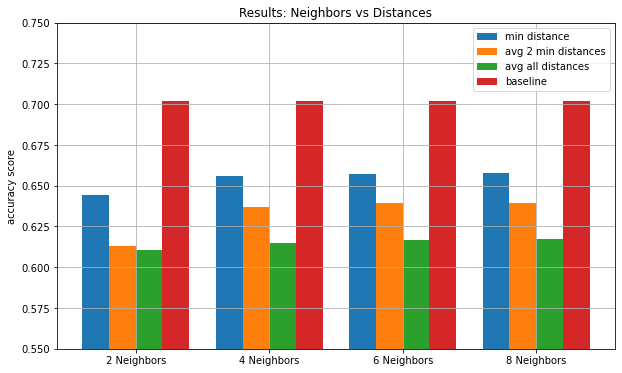

,2 Neighbors,4 Neighbors,6 Neighbors,8 Neighbors
min distance,0.64404,0.65624,0.65748,0.65764
avg 2 min distances,0.61284,0.63708,0.63912,0.63964
avg all distances,0.61048,0.61508,0.61700,0.61708
baseline,0.70220,0.70220,0.70220,0.70220


In [20]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))

def process_results(avg_r, min_r, min2_r):
    avg_r, base_r = zip(*avg_r)
    return [np.average(i) for i in [min_r, min2_r, avg_r, base_r]]

neighbor_8 = process_results(avg_results_5_8_5, min_results_5_8_5, min2_results_5_8_5)
neighbor_6 = process_results(avg_results_5_6_5, min_results_5_6_5, min2_results_5_6_5)
neighbor_4 = process_results(avg_results_5_4_5, min_results_5_4_5, min2_results_5_4_5)
neighbor_2 = process_results(avg_results_5_2_5, min_results_5_2_5, min2_results_5_2_5)

ind = np.arange(4)
labels = ['min distance', 'avg 2 min distances', 'avg all distances', 'baseline']
width = 0.2

for i, j in enumerate(zip(neighbor_2, neighbor_4, neighbor_6, neighbor_8)):
    plt.bar(ind+i*width, j, width, label=labels[i])

plt.ylim(0.55, 0.75)
plt.legend(loc="upper right")
plt.title("Results: Neighbors vs Distances")
x_lbls='2 Neighbors', '4 Neighbors', '6 Neighbors', '8 Neighbors'
plt.ylabel('accuracy score')
plt.xticks(ind + 1.5*width, x_lbls)
plt.grid()
plt.show()
pd.DataFrame(zip(neighbor_2, neighbor_4, neighbor_6, neighbor_8), columns=x_lbls, index=labels)

# Initial Results

In the graph above, we show the accuracy rates of running our entity linking algorithm on several models over **5 runs** utilizing the same **sequence of random seeds**:

We used four methods to choose our candidate_id (represented by the bolded text below)
1. Embedding Model: Select the candidate from the product with the lowest distane:
    1. **Avg** - Average all the pair distances.
    2. **2 min** - Average the two lowest pair distances.
    3. **min** - Take the min of the pair distances.
4. **Baseline** - ignore neighbors and select the candidate with the highest view-count

We also varied the number of neighbor between 2, 4, 6 and 8 for each test set.

### Initial Results - Discussion
We note that none of the preliminary models could beat the baseline model. The baseline model's performance make intuitive sense, since it selects entities based on the highest views on Wikipedia and we are testing on text from Wikipedia. The baseline sets a high bar for performance and will be challenge for our embedding model to beat.

However, we get some important results from this initial test. We can see that the embedding model that selected a candiate based on the pair with the lowest cosine distance in a product (**min**) produced the best results. Averaging all the distances produced the worst results.

We also see that the embedding models performed the worst with only 2 neighbors. 4, 6 and 8 neighbors produced very similar results. This means that the pair with the **lowest distance** is within the **first 4 neighbors**.

The results also give us some hope that our **min** embedding model has the potential to beat the baseline and will be the starting point for the next stage of tests.

In [21]:
%%time
# Test increasing the number of candidate and neighbor ids
# All runs takes the minimum of the pair distances with 4 neighbors
min_results_5_4_10 = run_model(samples_per_iter=5000, iterations=5, seed=1636, \
                          max_candidate_ids=5, max_neighbors=4, max_neighbor_ids=10, \
                          num_distances=1, cutoff=1, tune=0, skip_nonroot=True, verbose=False)
min_results_10_4_5 = run_model(samples_per_iter=5000, iterations=5, seed=1636, \
                          max_candidate_ids=10, max_neighbors=4, max_neighbor_ids=5, \
                          num_distances=1, cutoff=1, tune=0, skip_nonroot=True, verbose=False)
min_results_10_4_10 = run_model(samples_per_iter=5000, iterations=5, seed=1636, \
                          max_candidate_ids=10, max_neighbors=4, max_neighbor_ids=10, \
                          num_distances=1, cutoff=1, tune=0, skip_nonroot=True, verbose=False)

Run: 0	embedding model results: 0.6574	time:16.279025554656982
Run: 1	embedding model results: 0.6568	time:15.432007312774658
Run: 2	embedding model results: 0.6562	time:13.788188695907593
Run: 3	embedding model results: 0.6546	time:13.940263986587524
Run: 4	embedding model results: 0.6536	time:13.502338171005249
Run: 0	embedding model results: 0.6538	time:8.21359395980835
Run: 1	embedding model results: 0.6538	time:8.343407392501831
Run: 2	embedding model results: 0.6532	time:7.927807807922363
Run: 3	embedding model results: 0.6524	time:8.075305938720703
Run: 4	embedding model results: 0.6524	time:7.902083873748779
Run: 0	embedding model results: 0.6546	time:22.71076202392578
Run: 1	embedding model results: 0.6544	time:21.992528676986694
Run: 2	embedding model results: 0.6524	time:18.281537771224976
Run: 3	embedding model results: 0.6512	time:19.32702612876892
Run: 4	embedding model results: 0.6514	time:19.10930585861206
CPU times: user 24 s, sys: 13.5 s, total: 37.6 s
Wall time: 3min

In [22]:
%%time
# Testing reducing the number of candidate and neighbor ids
# All runs takes the minimum of the pair distances with 4 neighbors
min_results_5_4_3 = run_model(samples_per_iter=5000, iterations=5, seed=1636, \
                              max_candidate_ids=5, max_neighbors=4, max_neighbor_ids=3, \
                              num_distances=1, cutoff=1, tune=0, skip_nonroot=True, verbose=False)
min_results_3_4_5 = run_model(samples_per_iter=5000, iterations=3, seed=1636, \
                              max_candidate_ids=3, max_neighbors=5, max_neighbor_ids=5, \
                              num_distances=1, cutoff=1, tune=0, skip_nonroot=True, verbose=False)
min_results_3_4_3 = run_model(samples_per_iter=5000, iterations=3, seed=1636, \
                              max_candidate_ids=3, max_neighbors=5, max_neighbor_ids=3, \
                              num_distances=1, cutoff=1, tune=0, skip_nonroot=True, verbose=False)

Run: 0	embedding model results: 0.656	time:6.289856672286987
Run: 1	embedding model results: 0.6578	time:6.475723028182983
Run: 2	embedding model results: 0.6572	time:6.172241926193237
Run: 3	embedding model results: 0.6552	time:6.303820371627808
Run: 4	embedding model results: 0.6544	time:6.2078070640563965
Run: 0	embedding model results: 0.6628	time:7.921476602554321
Run: 1	embedding model results: 0.6646	time:8.44571566581726
Run: 2	embedding model results: 0.661	time:7.8685243129730225
Run: 0	embedding model results: 0.6628	time:6.281347274780273
Run: 1	embedding model results: 0.6662	time:6.615871906280518
Run: 2	embedding model results: 0.661	time:6.201300621032715
CPU times: user 17.4 s, sys: 12.7 s, total: 30.2 s
Wall time: 1min 28s


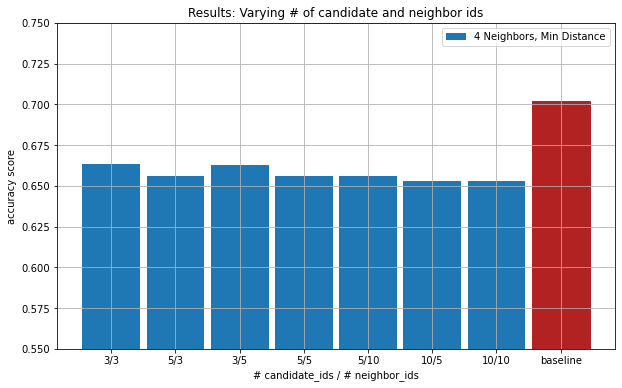

,Min 4
# candidate_ids / # neighbor_ids,
3/3,0.663333
5/3,0.656120
3/5,0.662800
5/5,0.656240
5/10,0.655720
10/5,0.653120
10/10,0.652800
baseline,0.702200


In [23]:
plt.figure(figsize=(10,6))

min_4 = [np.average(i) for i in [min_results_3_4_3, min_results_5_4_3, min_results_3_4_5, \
                                 min_results_5_4_5, min_results_5_4_10, min_results_10_4_5, min_results_10_4_10]]
min_4 += [neighbor_4[3]]

ind = np.arange(0, len(min_4), 1)
width = 0.9
labels = ['3/3', '5/3', '3/5', '5/5', '5/10', '10/5', '10/10', 'baseline']

barlist=plt.bar(ind, min_4, width, label='4 Neighbors, Min Distance')
barlist[-1].set_color('firebrick')

plt.ylim(0.55, 0.75)
plt.legend(loc="upper right")
plt.title("Results: Varying # of candidate and neighbor ids")
plt.ylabel('accuracy score')
plt.xlabel('# candidate_ids / # neighbor_ids')
plt.xticks(ind, labels)
plt.grid()
plt.show()

min_4_df = pd.DataFrame(min_4, columns=['Min 4'], index=labels)
min_4_df.index.rename('# candidate_ids / # neighbor_ids', inplace=True)
min_4_df

### Initial Results - Discussion
#### Varying # of candidate and neighbor ids
It appears varying the number of candidate ids does not impact the accuracy significantly. Constraining the model to the 3 most popular entities increases the score marginally ~0.8%. However the limited number of ids limits the ability of our model to maximize the relationship between embeddings. Thus, we will continue to use 5 or more candidate ids and neighbor ids.

# Model Analysis
We will now examine cases where our model and the baseline model predict different candidates. By isolating cases where our model outperforms and underperforms the baseline we can gain insight into what distances imply strong relationships between entities.

We will use 2 sets of parameters and average the results for each other 5 runs:
    1. 5 candidate_ids, 4 neighbors and 10 neighbor_ids
    2. 10 candidate_ids, 6 neighbors and 10 neighbor_ids


In [24]:
%%time
# Tuning results
analysis_4 = run_model(samples_per_iter=5000, iterations=5, seed=1636, \
                       max_candidate_ids=5, max_neighbors=4, max_neighbor_ids=5, \
                       num_distances=1, cutoff=1, tune=0, skip_nonroot=True, verbose=True)

display(pd.concat(analysis_4,axis=1))

Run: 0	samples: 5000	Time:7.276838064193726
Run: 1	samples: 5000	Time:7.480013132095337
Run: 2	samples: 5000	Time:7.067780494689941
Run: 3	samples: 5000	Time:7.244342565536499
Run: 4	samples: 5000	Time:7.111274003982544


result             Baseline Correct  Both Incorrect  Model Correct  \
model_dist  count        286.000000      239.000000      84.000000   
            mean           0.001968        0.001729       0.000915   
            std            0.002559        0.002177       0.002110   
            min            0.000000        0.000000       0.000003   
            25%            0.000318        0.000251       0.000046   
            50%            0.001478        0.001223       0.000177   
            75%            0.002284        0.002002       0.001068   
            max            0.021253        0.012220       0.017161   
cand_0_dist count        286.000000      239.000000      84.000000   
            mean           0.015099        0.054266       0.015008   
            std            0.101725        0.217950       0.108831   
            min            0.000015        0.000017       0.000012   
            25%            0.000819        0.001672       0.000256   
            50%            0.002631        0.002720       0.001973   
            75%            0.006239        0.005053       0.004123   
            max            1.000000        1.000000       1.000000   
diff        count        286.000000      239.000000      84.000000   
            mean           0.013131        0.052537       0.014093   
            std            0.101635        0.217559       0.108875   
            min            0.000000        0.000000       0.000000   
            25%            0.000129        0.000360       0.000080   
            50%            0.000852        0.001481       0.001203   
            75%            0.003704        0.003471       0.002890   
            max            0.998680        0.999977       0.999663   
diff_pct    count        286.000000      239.000000      84.000000   
            mean           0.446118        0.528143       0.630113   
            std            0.281614        0.319002       0.321719   
            min            0.001707        0.001010       0.001796   
            25%            0.217843        0.249386       0.357824   
            50%            0.413984        0.553830       0.688677   
            75%            0.679146        0.798212       0.933794   
            max            1.000000        1.000000       0.999663   

result             Baseline Correct  Both Incorrect  Model Correct  \
model_dist  count        331.000000      202.000000     105.000000   
            mean           0.001786        0.001687       0.001080   
            std            0.001988        0.001807       0.002850   
            min            0.000000        0.000000       0.000006   
            25%            0.000237        0.000279       0.000043   
            50%            0.001462        0.001479       0.000113   
            75%            0.002185        0.002229       0.001010   
            max            0.016411        0.012006       0.019290   
cand_0_dist count        331.000000      202.000000     105.000000   
            mean           0.016435        0.063556       0.031071   
            std            0.109060        0.235972       0.167013   
            min            0.000019        0.000019       0.000008   
            25%            0.000760        0.001410       0.000196   
            50%            0.002611        0.002730       0.001684   
            75%            0.006624        0.006663       0.003384   
            max            1.000000        1.000000       1.000000   
diff        count        331.000000      202.000000     105.000000   
            mean           0.014650        0.061869       0.029991   
            std            0.108915        0.235816       0.166430   
            min            0.000000        0.000000       0.000002   
            25%            0.000093        0.000270       0.000065   
            50%            0.000867        0.001350       0.001174   
            75%            0.003748        0.004821       0.002246   
         

CPU times: user 8.23 s, sys: 5.1 s, total: 13.3 s
Wall time: 41.1 s


In [25]:
%%time
# Tuning results
analysis_6 = run_model(samples_per_iter=5000, iterations=5, seed=1636, \
                       max_candidate_ids=10, max_neighbors=6, max_neighbor_ids=10, \
                       num_distances=1, cutoff=1, tune=0, skip_nonroot=True, verbose=True)
display(pd.concat(analysis_6,axis=1))

Run: 0	samples: 5000	Time:31.145851373672485
Run: 1	samples: 5000	Time:33.60737752914429
Run: 2	samples: 5000	Time:29.035520792007446
Run: 3	samples: 5000	Time:28.38433313369751
Run: 4	samples: 5000	Time:27.94204568862915


result             Baseline Correct  Both Incorrect  Model Correct  \
model_dist  count        296.000000      249.000000      83.000000   
            mean           0.001683        0.001413       0.000786   
            std            0.002299        0.001706       0.002049   
            min            0.000000        0.000000       0.000003   
            25%            0.000272        0.000241       0.000027   
            50%            0.001320        0.001148       0.000112   
            75%            0.001947        0.001678       0.000945   
            max            0.021253        0.011655       0.017161   
cand_0_dist count        296.000000      249.000000      83.000000   
            mean           0.014485        0.051979       0.014341   
            std            0.100035        0.213804       0.109561   
            min            0.000015        0.000017       0.000012   
            25%            0.000590        0.001546       0.000193   
            50%            0.002265        0.002261       0.001308   
            75%            0.006035        0.004599       0.002419   
            max            1.000000        1.000000       1.000000   
diff        count        296.000000      249.000000      83.000000   
            mean           0.012802        0.050566       0.013554   
            std            0.099926        0.213715       0.109598   
            min            0.000000        0.000000       0.000000   
            25%            0.000093        0.000327       0.000069   
            50%            0.000708        0.001106       0.000867   
            75%            0.003518        0.003305       0.001683   
            max            0.998680        0.999977       0.999752   
diff_pct    count        296.000000      249.000000      83.000000   
            mean           0.452733        0.531608       0.629388   
            std            0.294040        0.320696       0.323733   
            min            0.001707        0.001010       0.001796   
            25%            0.198194        0.242477       0.355493   
            50%            0.419046        0.525617       0.694592   
            75%            0.705880        0.833110       0.948143   
            max            1.000000        1.000000       0.999752   

result             Baseline Correct  Both Incorrect  Model Correct  \
model_dist  count        338.000000      213.000000     109.000000   
            mean           0.001598        0.001451       0.000715   
            std            0.001881        0.001637       0.002022   
            min            0.000000        0.000000       0.000000   
            25%            0.000243        0.000243       0.000033   
            50%            0.001324        0.001275       0.000097   
            75%            0.001929        0.001840       0.000612   
            max            0.016411        0.014987       0.018302   
cand_0_dist count        338.000000      213.000000     109.000000   
            mean           0.015929        0.060108       0.029381   
            std            0.107963        0.230243       0.164070   
            min            0.000019        0.000019       0.000008   
            25%            0.000720        0.001359       0.000187   
            50%            0.002216        0.002167       0.001356   
            75%            0.006249        0.005998       0.002269   
            max            1.000000        1.000000       1.000000   
diff        count        338.000000      213.000000     109.000000   
            mean           0.014331        0.058657       0.028666   
            std            0.107802        0.230113       0.163646   
            min            0.000000        0.000000       0.000002   
            25%            0.000096        0.000286       0.000065   
            50%            0.000723        0.000960       0.000798   
            75%            0.003506        0.003958       0.001842   
         

CPU times: user 8.38 s, sys: 5 s, total: 13.4 s
Wall time: 2min 35s


In [26]:
# average tuning results over 5 runs
analysis_avg_df = pd.concat([sum(analysis_4)/len(analysis_4), sum(analysis_6)/len(analysis_6)], axis=1)
analysis_avg_df.round(6)

result             Baseline Correct  Both Incorrect  Model Correct  \
model_dist  count        321.000000      217.200000      91.200000   
            mean           0.001891        0.001773       0.000970   
            std            0.002321        0.002315       0.002087   
            min            0.000005        0.000001       0.000007   
            25%            0.000267        0.000236       0.000045   
            50%            0.001436        0.001313       0.000173   
            75%            0.002286        0.002078       0.001235   
            max            0.017822        0.015118       0.015101   
cand_0_dist count        321.000000      217.200000      91.200000   
            mean           0.019485        0.063702       0.024564   
            std            0.118917        0.235061       0.144656   
            min            0.000017        0.000015       0.000013   
            25%            0.000709        0.001536       0.000398   
            50%            0.002484        0.002762       0.001835   
            75%            0.006412        0.005801       0.003982   
            max            1.000000        1.000000       1.000000   
diff        count        321.000000      217.200000      91.200000   
            mean           0.017594        0.061929       0.023593   
            std            0.118688        0.234828       0.144551   
            min            0.000000        0.000000       0.000001   
            25%            0.000097        0.000342       0.000102   
            50%            0.000911        0.001408       0.001062   
            75%            0.003606        0.003686       0.002545   
            max            0.998464        0.999577       0.999757   
diff_pct    count        321.000000      217.200000      91.200000   
            mean           0.441018        0.543098       0.608790   
            std            0.283828        0.311822       0.323667   
            min            0.001154        0.002493       0.002677   
            25%            0.183835        0.270927       0.314854   
            50%            0.424183        0.563479       0.659049   
            75%            0.673033        0.812867       0.920797   
            max            0.999445        0.999891       0.999779   

result             Baseline Correct  Both Incorrect  Model Correct  
model_dist  count        329.600000      230.200000      87.600000  
            mean           0.001618        0.001474       0.000794  
            std            0.002016        0.001955       0.001917  
            min            0.000003        0.000000       0.000005  
            25%            0.000241        0.000223       0.000036  
            50%            0.001306        0.001173       0.000120  
            75%            0.001908        0.001723       0.000916  
            max            0.016244        0.015051       0.014903  
cand_0_dist count        329.600000      230.200000      87.600000  
            mean           0.018818        0.059018       0.027531  
            std            0.117408        0.226812       0.154878  
            min            0.000016        0.000015       0.000013  
            25%            0.000622        0.001402       0.000292  
            50%            0.002092        0.002210       0.001360  
            75%            0.006050        0.005104       0.002521  
            max            1.000000        1.000000       1.000000  
diff        count        329.600000      230.200000      87.600000  
            mean           0.017200        0.057544       0.026737  
            std            0.117206        0.226652       0.154788  
            min            0.000000        0.000000       0.000001  
            25%            0.000089        0.000313       0.000091  
            50%            0.000717        0.001113       0.000840  
            75%            0.003507        0.003299       0.001779  
            max            0.9985

## Model Analysis - Results
Our model and the baseline model recommend different candidates in \~12.5% (~640/5000) of the total cases.
- The embedding model outperforms the baseline in ~14% of those cases.
- The baseline model performs better in ~50% of those cases

However we see some promise in the variance in distances between when the embedding model is correct compared to the baseline model. Additionally, there may be a relationship between how much lower the distance of the candidate the embedding models selects is compared to the most popular candidate.

Key takeaways from our analysis:
- Embedding Model is Correct:
    1. The median distance is: ~0.00015
    2. The median pct diff between the distance of the selected candidate and the most popular candidate: ~67%
- Baseline Model is Correct:
    1. The median distance is:  ~0.0014
    2. The median pct diff between the distance of the selected candidate and the most popular candidate: ~42%

# Model Tuning

### Tuning Parameters:
   - **cutoff:** any distance above the cutoff will be set to 1.
   - **tune:** the distance of the candidate our model chooses must be the tune percentage lower than the distance of the candidate with the most view. If not, we will select the candidate with the most view.
   
We will tune our model using the finding from our analysis and see if we can improve the results. We will use values from the **25% to 75% range** from the **'Model Correct'** columns and the **'model_dist'** and **'diff_pct'** sections to set range we will test for the **cutoff and tune parameters** respectively.

In [27]:
# helper function to average results while tuning the model
def get_tune_result(result):
    avg_df = sum(result)/len(result)
    count = avg_df.loc['model_dist'].loc['count']
    return count

# generate the set of samples we will use to tune
# this saves us from recreating them for every run to save time
formatted_sample_list = run_model(samples_per_iter=5000, iterations=5, seed=1636, \
                                  max_candidate_ids=5, max_neighbors=4, max_neighbor_ids=5, \
                                  samples_only=True)

print(len(formatted_sample_list), len(formatted_sample_list[0]))

5 5000


In [28]:
cutoff_range = np.append(np.arange(0.0001, 0.001, 0.0001), np.arange(0.001, 0.0016, 0.0002))
tune_range = np.append(np.arange(0.4, 0.6, 0.05), np.arange(0.6, 0.825, 0.025))

print('Starting Tuning!')
print(f'cutoff values: {cutoff_range}')
print(f'tune values: {tune_range}')

tune_results_list = []
for c in cutoff_range:
    for i in tune_range:
        print(f'Running with parameters: cutoff={c} tune={i}')
        tune_results = run_model(samples_per_iter=None, iterations=5, seed=None, \
                                 max_candidate_ids=None, max_neighbors=None, max_neighbor_ids=None, \
                                 num_distances=1, cutoff=c, tune=i, skip_nonroot=True, \
                                 provided_samples=formatted_sample_list, verbose=True)
        
        tune_results_list.append([c, i, get_tune_result(tune_results)])


Starting Tuning!
cutoff values: [0.0001 0.0002 0.0003 0.0004 0.0005 0.0006 0.0007 0.0008 0.0009 0.001
 0.0012 0.0014]
tune values: [0.4   0.45  0.5   0.55  0.6   0.625 0.65  0.675 0.7   0.725 0.75  0.775
 0.8  ]
Running with parameters: cutoff=0.0001 tune=0.4
Run: 0	samples: None	Time:1.5752084255218506
Run: 1	samples: None	Time:1.5681719779968262
Run: 2	samples: None	Time:1.4114646911621094
Run: 3	samples: None	Time:1.4450125694274902
Run: 4	samples: None	Time:1.444901466369629
Running with parameters: cutoff=0.0001 tune=0.45
Run: 0	samples: None	Time:1.589728832244873
Run: 1	samples: None	Time:1.521298885345459
Run: 2	samples: None	Time:1.4110209941864014
Run: 3	samples: None	Time:1.425912857055664
Run: 4	samples: None	Time:1.439518928527832
Running with parameters: cutoff=0.0001 tune=0.5
Run: 0	samples: None	Time:1.5984807014465332
Run: 1	samples: None	Time:1.5510976314544678
Run: 2	samples: None	Time:1.4274511337280273
Run: 3	samples: None	Time:1.4269928932189941
Run: 4	samples: No

Run: 3	samples: None	Time:1.4263885021209717
Run: 4	samples: None	Time:1.4265966415405273
Running with parameters: cutoff=0.00030000000000000003 tune=0.55
Run: 0	samples: None	Time:1.6240451335906982
Run: 1	samples: None	Time:1.5549030303955078
Run: 2	samples: None	Time:1.4401347637176514
Run: 3	samples: None	Time:1.4129655361175537
Run: 4	samples: None	Time:1.425795555114746
Running with parameters: cutoff=0.00030000000000000003 tune=0.6
Run: 0	samples: None	Time:1.6657025814056396
Run: 1	samples: None	Time:1.4920148849487305
Run: 2	samples: None	Time:1.4333326816558838
Run: 3	samples: None	Time:1.401719331741333
Run: 4	samples: None	Time:1.419318437576294
Running with parameters: cutoff=0.00030000000000000003 tune=0.625
Run: 0	samples: None	Time:1.6330511569976807
Run: 1	samples: None	Time:1.5686731338500977
Run: 2	samples: None	Time:1.4697117805480957
Run: 3	samples: None	Time:1.4349501132965088
Run: 4	samples: None	Time:1.4141004085540771
Running with parameters: cutoff=0.000300000

Run: 3	samples: None	Time:1.429429054260254
Run: 4	samples: None	Time:1.4393706321716309
Running with parameters: cutoff=0.0005 tune=0.65
Run: 0	samples: None	Time:1.5905375480651855
Run: 1	samples: None	Time:1.523695707321167
Run: 2	samples: None	Time:1.4430654048919678
Run: 3	samples: None	Time:1.4511640071868896
Run: 4	samples: None	Time:1.4367551803588867
Running with parameters: cutoff=0.0005 tune=0.675
Run: 0	samples: None	Time:1.5959343910217285
Run: 1	samples: None	Time:1.5200870037078857
Run: 2	samples: None	Time:1.4407565593719482
Run: 3	samples: None	Time:1.4368045330047607
Run: 4	samples: None	Time:1.4104821681976318
Running with parameters: cutoff=0.0005 tune=0.7000000000000001
Run: 0	samples: None	Time:1.606363296508789
Run: 1	samples: None	Time:1.5418274402618408
Run: 2	samples: None	Time:1.4662718772888184
Run: 3	samples: None	Time:1.4383363723754883
Run: 4	samples: None	Time:1.4218966960906982
Running with parameters: cutoff=0.0005 tune=0.7250000000000001
Run: 0	sample

Run: 0	samples: None	Time:1.5756309032440186
Run: 1	samples: None	Time:1.5198054313659668
Run: 2	samples: None	Time:1.439605474472046
Run: 3	samples: None	Time:1.4560527801513672
Run: 4	samples: None	Time:1.4434781074523926
Running with parameters: cutoff=0.0007000000000000001 tune=0.7250000000000001
Run: 0	samples: None	Time:1.5908520221710205
Run: 1	samples: None	Time:1.5935757160186768
Run: 2	samples: None	Time:1.418339729309082
Run: 3	samples: None	Time:1.4294278621673584
Run: 4	samples: None	Time:1.4251890182495117
Running with parameters: cutoff=0.0007000000000000001 tune=0.7500000000000001
Run: 0	samples: None	Time:1.582911729812622
Run: 1	samples: None	Time:1.545088768005371
Run: 2	samples: None	Time:1.445225477218628
Run: 3	samples: None	Time:1.4706761837005615
Run: 4	samples: None	Time:1.433760404586792
Running with parameters: cutoff=0.0007000000000000001 tune=0.7750000000000001
Run: 0	samples: None	Time:1.5895037651062012
Run: 1	samples: None	Time:1.5920803546905518
Run: 2	

Run: 4	samples: None	Time:1.4146556854248047
Running with parameters: cutoff=0.0009000000000000001 tune=0.7750000000000001
Run: 0	samples: None	Time:1.6082963943481445
Run: 1	samples: None	Time:1.5072238445281982
Run: 2	samples: None	Time:1.4089961051940918
Run: 3	samples: None	Time:1.4424958229064941
Run: 4	samples: None	Time:1.4237351417541504
Running with parameters: cutoff=0.0009000000000000001 tune=0.8000000000000002
Run: 0	samples: None	Time:1.6027657985687256
Run: 1	samples: None	Time:1.5221245288848877
Run: 2	samples: None	Time:1.4416189193725586
Run: 3	samples: None	Time:1.4593493938446045
Run: 4	samples: None	Time:1.427900791168213
Running with parameters: cutoff=0.001 tune=0.4
Run: 0	samples: None	Time:1.612962245941162
Run: 1	samples: None	Time:1.5586390495300293
Run: 2	samples: None	Time:1.4272129535675049
Run: 3	samples: None	Time:1.4522459506988525
Run: 4	samples: None	Time:1.433889627456665
Running with parameters: cutoff=0.001 tune=0.45
Run: 0	samples: None	Time:1.5781

Run: 2	samples: None	Time:1.4313251972198486
Run: 3	samples: None	Time:1.452225685119629
Run: 4	samples: None	Time:1.4084298610687256
Running with parameters: cutoff=0.0014000000000000002 tune=0.45
Run: 0	samples: None	Time:1.579768419265747
Run: 1	samples: None	Time:1.5009303092956543
Run: 2	samples: None	Time:1.4083678722381592
Run: 3	samples: None	Time:1.4155941009521484
Run: 4	samples: None	Time:1.4077110290527344
Running with parameters: cutoff=0.0014000000000000002 tune=0.5
Run: 0	samples: None	Time:1.5846645832061768
Run: 1	samples: None	Time:1.4846765995025635
Run: 2	samples: None	Time:1.394995927810669
Run: 3	samples: None	Time:1.4192421436309814
Run: 4	samples: None	Time:1.4475908279418945
Running with parameters: cutoff=0.0014000000000000002 tune=0.55
Run: 0	samples: None	Time:1.6133642196655273
Run: 1	samples: None	Time:1.5558710098266602
Run: 2	samples: None	Time:1.4367988109588623
Run: 3	samples: None	Time:1.4314765930175781
Run: 4	samples: None	Time:1.4305050373077393
Ru

In [29]:
tune_results_df = pd.DataFrame([i[2] for i in tune_results_list])
tune_results_df['cutoff'] = [i[0] for i in tune_results_list]
tune_results_df['tune'] = [i[1] for i in tune_results_list]
tune_results_df.sort_values(by=['cutoff', 'tune'], ascending=[False, True], inplace=True)
tune_results_df['total'] = tune_results_df['Baseline Correct']+tune_results_df['Both Incorrect']+tune_results_df['Model Correct']
tune_results_df['pct_model_correct'] = tune_results_df['Model Correct']/tune_results_df['total']
tune_results_df['ratio_model_baseline'] = tune_results_df['Model Correct']/tune_results_df['Baseline Correct']
tune_results_df['difference'] = tune_results_df['Model Correct']-tune_results_df['Baseline Correct']
tune_results_df = tune_results_df[['cutoff', 'tune', 'Baseline Correct', 'Both Incorrect', 'Model Correct', 'total', 'pct_model_correct', 'ratio_model_baseline', 'difference']]
tune_results_df

result,cutoff,tune,Baseline Correct,Both Incorrect,Model Correct,total,pct_model_correct,ratio_model_baseline,difference
count,0.0014,0.400,73.2,81.8,54.4,209.4,0.259790,0.743169,-18.8
count,0.0014,0.450,60.6,77.8,51.4,189.8,0.270811,0.848185,-9.2
count,0.0014,0.500,53.6,72.4,50.0,176.0,0.284091,0.932836,-3.6
count,0.0014,0.550,48.0,69.8,48.4,166.2,0.291215,1.008333,0.4
count,0.0014,0.600,41.6,63.8,46.2,151.6,0.304749,1.110577,4.6
...,...,...,...,...,...,...,...,...,...
count,0.0001,0.700,9.6,18.0,21.4,49.0,0.436735,2.229167,11.8
count,0.0001,0.725,9.2,17.8,20.8,47.8,0.435146,2.260870,11.6
count,0.0001,0.750,9.2,17.8,19.8,46.8,0.423077,2.152174,10.6
count,0.0001,0.775,9.0,16.8,19.2,45.0,0.426667,2.133333,10.2


In [30]:
# sort our tuned models by ratio and difference between 'Model Correct' and 'Baseline Correct'
display(tune_results_df.sort_values(by=['pct_model_correct'], ascending=[False])[:10])
display(tune_results_df.sort_values(by=['difference', 'ratio_model_baseline'], ascending=[False, False])[:10])
display(tune_results_df.sort_values(by=['ratio_model_baseline', 'difference'], ascending=[False, False])[:10])

result,cutoff,tune,Baseline Correct,Both Incorrect,Model Correct,total,pct_model_correct,ratio_model_baseline,difference
count,0.0001,0.800,8.4,15.8,19.0,43.2,0.439815,2.261905,10.6
count,0.0001,0.700,9.6,18.0,21.4,49.0,0.436735,2.229167,11.8
count,0.0001,0.725,9.2,17.8,20.8,47.8,0.435146,2.260870,11.6
count,0.0001,0.600,12.2,19.0,24.0,55.2,0.434783,1.967213,11.8
count,0.0001,0.650,10.8,18.4,22.4,51.6,0.434109,2.074074,11.6
count,0.0001,0.550,13.8,20.0,25.8,59.6,0.432886,1.869565,12.0
count,0.0001,0.675,10.4,18.0,21.6,50.0,0.432000,2.076923,11.2
count,0.0001,0.625,11.6,18.8,23.0,53.4,0.430712,1.982759,11.4
count,0.0001,0.775,9.0,16.8,19.2,45.0,0.426667,2.133333,10.2
count,0.0001,0.750,9.2,17.8,19.8,46.8,0.423077,2.152174,10.6


result,cutoff,tune,Baseline Correct,Both Incorrect,Model Correct,total,pct_model_correct,ratio_model_baseline,difference
count,0.0008,0.725,18.6,44.0,36.6,99.2,0.368952,1.967742,18.0
count,0.0008,0.800,15.0,37.6,32.6,85.2,0.382629,2.173333,17.6
count,0.0007,0.725,18.4,43.4,36.0,97.8,0.368098,1.956522,17.6
count,0.0007,0.800,14.8,37.2,32.2,84.2,0.382423,2.175676,17.4
count,0.0009,0.725,19.8,45.6,37.2,102.6,0.362573,1.878788,17.4
count,0.0008,0.650,22.4,47.2,39.8,109.4,0.363803,1.776786,17.4
count,0.0008,0.700,20.4,45.0,37.6,103.0,0.365049,1.843137,17.2
count,0.0008,0.600,24.8,48.4,42.0,115.2,0.364583,1.693548,17.2
count,0.0009,0.800,15.6,38.8,32.8,87.2,0.376147,2.102564,17.2
count,0.0008,0.750,18.0,43.2,35.0,96.2,0.363825,1.944444,17.0


result,cutoff,tune,Baseline Correct,Both Incorrect,Model Correct,total,pct_model_correct,ratio_model_baseline,difference
count,0.0001,0.800,8.4,15.8,19.0,43.2,0.439815,2.261905,10.6
count,0.0001,0.725,9.2,17.8,20.8,47.8,0.435146,2.260870,11.6
count,0.0002,0.800,11.6,25.6,26.2,63.4,0.413249,2.258621,14.6
count,0.0001,0.700,9.6,18.0,21.4,49.0,0.436735,2.229167,11.8
count,0.0007,0.800,14.8,37.2,32.2,84.2,0.382423,2.175676,17.4
count,0.0008,0.800,15.0,37.6,32.6,85.2,0.382629,2.173333,17.6
count,0.0002,0.725,13.0,29.2,28.2,70.4,0.400568,2.169231,15.2
count,0.0001,0.750,9.2,17.8,19.8,46.8,0.423077,2.152174,10.6
count,0.0002,0.775,12.4,27.0,26.6,66.0,0.403030,2.145161,14.2
count,0.0004,0.800,14.2,34.8,30.4,79.4,0.382872,2.140845,16.2


In [31]:
print(f'{len(tune_results_df[tune_results_df.difference>0])}/{len(tune_results_df)} \
sets of parameters outperformed the baseline')

151/156 sets of parameters outperformed the baseline


## Model Tuning - Results
### The Embedding Model Works!

Our tuning shows our model **outperforming the baseline!** We now have a table of parameters where our model outperforms the baseline.

Now we will run **five optimized models** based on the top results from the table above and use the parameter set with the highest accuracy score for our final model.

In [94]:
optimized_params = [(0.0001, 0.8), (0.0008, 0.725), (0.0001, 0.725), (0.0008, 0.8), (0.0002, 0.8)]
optimized_results = []

for c, t in optimized_params:
    optimized_results.append(run_model(samples_per_iter=None, iterations=5, seed=None, \
                                       max_candidate_ids=None, max_neighbors=None, max_neighbor_ids=None, \
                                       num_distances=1, cutoff=c, tune=t, skip_nonroot=True, \
                                       provided_samples=formatted_sample_list, verbose=False))

Run: 0	embedding model results: 0.699	time:1.6105647087097168
Run: 1	embedding model results: 0.7054	time:1.5345933437347412
Run: 2	embedding model results: 0.7094	time:1.4549684524536133
Run: 3	embedding model results: 0.7028	time:1.4472508430480957
Run: 4	embedding model results: 0.705	time:1.4509289264678955
Run: 0	embedding model results: 0.7008	time:1.584244966506958
Run: 1	embedding model results: 0.7076	time:1.616020679473877
Run: 2	embedding model results: 0.711	time:1.4264001846313477
Run: 3	embedding model results: 0.7022	time:1.4595158100128174
Run: 4	embedding model results: 0.7074	time:1.4472405910491943
Run: 0	embedding model results: 0.6992	time:1.6456859111785889
Run: 1	embedding model results: 0.7056	time:1.564849853515625
Run: 2	embedding model results: 0.7096	time:1.4378962516784668
Run: 3	embedding model results: 0.7026	time:1.458756446838379
Run: 4	embedding model results: 0.7056	time:1.4320368766784668
Run: 0	embedding model results: 0.7002	time:1.633317470550537


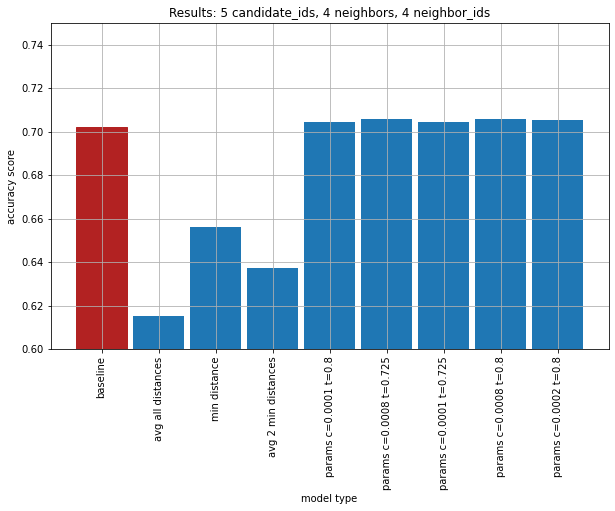

,Accuracy
# candidate_ids / # neighbor_ids,
baseline,0.70220
avg all distances,0.61508
min distance,0.65624
avg 2 min distances,0.63708
params c=0.0001 t=0.8,0.70432
params c=0.0008 t=0.725,0.70580
params c=0.0001 t=0.725,0.70452
params c=0.0008 t=0.8,0.70572
params c=0.0002 t=0.8,0.70512


In [95]:
plt.figure(figsize=(10,6))

avg_result, base_result = zip(*avg_results_5_4_5)
neighbor_4_opti = [base_result, avg_result, min_results_5_4_5, min2_results_5_4_5] + optimized_results
neighbor_4_opti = [np.average(i) for i in neighbor_4_opti]
                        
ind = np.arange(0, len(neighbor_4_opti), 1)
width = 0.9
labels = ['baseline', 'avg all distances', 'min distance', 'avg 2 min distances']
labels += [f'params c={c} t={t}' for c, t in optimized_params]

barlist=plt.bar(ind, neighbor_4_opti, width, label='4 Neighbors')
barlist[0].set_color('firebrick')

plt.ylim(0.6, 0.75)
plt.title("Results: 5 candidate_ids, 4 neighbors, 4 neighbor_ids")
plt.ylabel('accuracy score')
plt.xlabel('model type')
plt.xticks(ind, labels, rotation=90)
plt.grid()
plt.show()

min_4_df = pd.DataFrame(neighbor_4_opti, columns=['Accuracy'], index=labels)
min_4_df.index.rename('# candidate_ids / # neighbor_ids', inplace=True)
min_4_df

# Final Model

### Settings

Here are the parameters of our **final model** based on the best performing optimized embedding model above.

| Parameter         | Value  |
|-------------------|--------|
| max_candidate_ids | 5      |
| max_neighbors     | 4      |
| max_neighbor_ids  | 5      |
| num_distances     | 1      |
| cutoff            | 0.0008 |
| tune              | 0.725  |

## Final Model - Test
Up to this point we've been using same sequence of random seeds for all our tests. We will not use seeds for our final test run.

For our final sequence of tests we will run our final model with **10 sets of 5000 random samples**.

In [96]:
%%time
final_test_results = run_model(samples_per_iter=5000, iterations=10, seed=None, \
                               max_candidate_ids=5, max_neighbors=4, max_neighbor_ids=5, \
                               num_distances=1, cutoff=0.0008, tune=0.725, skip_nonroot=True, \
                               verbose=False, compare=True)


Run: 0	embedding model results: 0.7002	baseline results: 0.694	time:7.796745777130127
Run: 1	embedding model results: 0.71	baseline results: 0.7086	time:7.898545503616333
Run: 2	embedding model results: 0.7038	baseline results: 0.702	time:7.326197385787964
Run: 3	embedding model results: 0.7002	baseline results: 0.695	time:7.938142538070679
Run: 4	embedding model results: 0.7004	baseline results: 0.696	time:7.1620399951934814
Run: 5	embedding model results: 0.7052	baseline results: 0.7014	time:7.432491302490234
Run: 6	embedding model results: 0.7048	baseline results: 0.7034	time:7.214053392410278
Run: 7	embedding model results: 0.7122	baseline results: 0.7072	time:7.678871154785156
Run: 8	embedding model results: 0.7052	baseline results: 0.7018	time:7.390840768814087
Run: 9	embedding model results: 0.7038	baseline results: 0.701	time:7.306101560592651
CPU times: user 16.3 s, sys: 5.05 s, total: 21.4 s
Wall time: 1min 19s


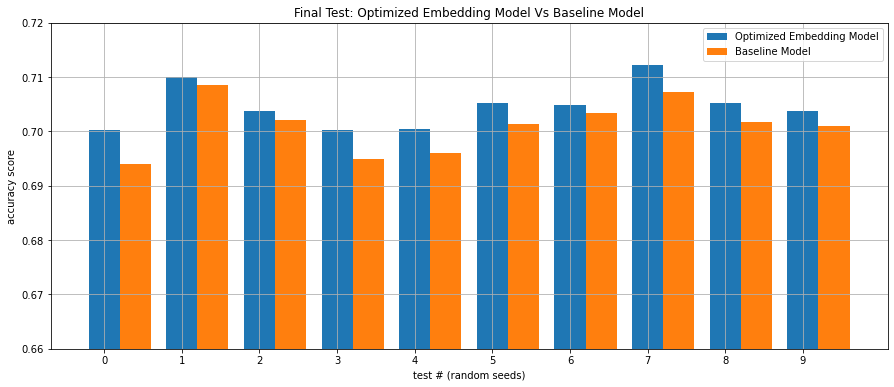

In [99]:
plt.figure(figsize=(15,6))

final_model_results, baseline_results = zip(*final_test_results)

ind = np.arange(len(final_model_results))
width = 0.4

plt.bar(ind, final_model_results, width, label='Optimized Embedding Model')
plt.bar(ind+width, baseline_results, width, label='Baseline Model')

plt.ylim(0.66, 0.72)
plt.legend(loc="upper right")
plt.title("Final Test: Optimized Embedding Model Vs Baseline Model")
x_lbls='2 Neighbors', '4 Neighbors', '6 Neighbors', '8 Neighbors'
plt.ylabel('accuracy score')
plt.xticks(ind)
plt.xlabel('test # (random seeds)')
plt.grid()
plt.show()

## Final Model - Test
The final model outperforms the baseline in all 10 test runs. This provides conclusive evidence that our final model is superior to the baseline model.

# Conclusion
We can claim success in our hypothesis that the neighbors around an entity can help predict it's true id. While the score may not be substantially higher than the baseline, it is an improvement using an entirely different metric to select the true_id for an entity.

We believe our model will demonstrate greater success on non-wikipedia text compared to the baseline model. The baseline model utilizing the highest view was always a challenge to beat with our model. Since the views are genereated from Wikipedia traffic and our dataset was also created from Wikipedia.

Overall this project was challenging as there was a significant amount of data-pre-processing required before we could even start testing our model. Generating a set of embeddings required us to weight over 1000 properties and create a way to condense a graph by 87% while maintaining relationships between entities.

The initial results of the embedding model were not promising as it was outperformed by the baseline by at least 5% in all 18 initial test cases. However, after analyzing when our model was correct compared to the baseline, we realized that our model was successfully identifying relationships between an entity and its neighbors but it was also identifying weak relationships that should be ignored. We were able to tune the embedding model to maximize the relationship between the entity and its neighbor when it was sufficiently strong. This resulted in our optimized embedding model beating the baseline in all 10 tests runs with 5000 randomized samples each.

In the end, we accomplished our objective of utilizing graph embeddings to disambiguate an entity through its relationship with its neighboring entities.

## Future Work
We believe there is still room for improvement with the embedding model. We were only able to generate embedding for ~13% of the graph due to system constraints. We may be able to improve the relationship between entities if we are able to generate embeddings based on the entire 141M statements in the original graph. There may also be some additional fine-tuning possible for the cutoff and tune parameters.